In [1]:
# import libraries for Twitter API and model

In [2]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


In [4]:
from textblob import TextBlob
import tweepy
import sys
import datetime, time
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sharraeallen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharraeallen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
api_key = 'HkE5YJuv01c4bbq1GVc8SfNo4'
api_key_secret = 'fdSpo4SJjOKgDBtitXcKZ4s6Oe2KAgZDtwGoQ1JFoZre02AjT4'
access_token = '455536583-boFHn3N5TG6dDrTT0sJHbB0ehyzHyRZkakLCSkQ3'
access_token_secret = 'Ygw5qCpWu0RLL3KJnt3SKzjUqgQg1rtkUdJPVuDSeDROU'

auth_handler = tweepy.OAuthHandler(consumer_key=api_key, consumer_secret=api_key_secret)
auth_handler.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth_handler)

## DNC Account into dataframe

In [7]:
user = 'TheDemocrats' 
posts = tweepy.Cursor(api.user_timeline, screen_name=user).items(5000)
tweets1 = []

for status in posts:
      if status.lang == 'en':
        data = {'user': [status.user.name],
        'account_name':['@'+status.user.screen_name], 
        'tweet': [status.text]}
        tweets1.append(data)

df_dnc = pd.DataFrame(tweets1)

df_dnc.head()

,user,account_name,tweet
0,[The Democrats],[@TheDemocrats],[Why are Republicans opposing President Biden’...
1,[The Democrats],[@TheDemocrats],[NEW: Republicans have nominated ultra-MAGA ex...
2,[The Democrats],[@TheDemocrats],"[Last night, Republicans nominated a slew of u..."
3,[The Democrats],[@TheDemocrats],"[Three years ago today, President Biden kicked..."
4,[The Democrats],[@TheDemocrats],[Facts. https://t.co/49WM8KoanR]


In [8]:
df_dnc.shape

(3233, 3)

In [9]:
df_dnc

,user,account_name,tweet
0,[The Democrats],[@TheDemocrats],[Why are Republicans opposing President Biden’...
1,[The Democrats],[@TheDemocrats],[NEW: Republicans have nominated ultra-MAGA ex...
2,[The Democrats],[@TheDemocrats],"[Last night, Republicans nominated a slew of u..."
3,[The Democrats],[@TheDemocrats],"[Three years ago today, President Biden kicked..."
4,[The Democrats],[@TheDemocrats],[Facts. https://t.co/49WM8KoanR]
...,...,...,...
3228,[The Democrats],[@TheDemocrats],"[RT @POTUS: Today, I’m joining Vice President ..."
3229,[The Democrats],[@TheDemocrats],[.@POTUS’s American Jobs Plan will revitalize ...
3230,[The Democrats],[@TheDemocrats],[More than 156 million Americans have more mon...
3231,[The Democrats],[@TheDemocrats],[Republican state legislators have introduced ...


In [10]:
df_dnc.columns

Index(['user', 'account_name', 'tweet'], dtype='object')

In [11]:
#Separate the text of the tweets
dnc_tweet = df_dnc.drop(['user', 'account_name'], axis=1)
dnc_tweet.head()

,tweet
0,[Why are Republicans opposing President Biden’...
1,[NEW: Republicans have nominated ultra-MAGA ex...
2,"[Last night, Republicans nominated a slew of u..."
3,"[Three years ago today, President Biden kicked..."
4,[Facts. https://t.co/49WM8KoanR]


In [12]:
print(dnc_tweet['tweet'].iloc[0],'\n')

['Why are Republicans opposing President Biden’s plans to ensure billionaires pay their fair share in taxes, reduce t… https://t.co/23RImFh0Hx'] 



In [13]:
dnc_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   3233 non-null   object
dtypes: object(1)
memory usage: 25.4+ KB


## Cleaning

In [14]:
# Cleaning data with RegEx functions to remove symbols, punctuation, stopwords and links

def cleaning_round1(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",str(tweet)) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", str(tweet)) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    return tweet

In [15]:
dnc_tweet['tweet'] = dnc_tweet['tweet'].map(lambda x: cleaning_round1(x))
dnc_tweet.head()

,tweet
0,['Why are Republicans opposing President Biden...
1,['NEW: Republicans have nominated ultra-MAGA e...
2,"['Last night, Republicans nominated a slew of ..."
3,"[""Three years ago today, President Biden kicke..."
4,['Facts.


In [16]:
# Removing punctuation and brackets  

def cleaning_round2(tweet):
    tweet = str(tweet).lower()
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub(r'\brt\b', '',tweet).strip() #Remove 'rt' as retweet label
    tweet = str(tweet).replace('[','').replace(']','').replace('\'','').replace('\"','')
    return tweet

In [17]:
dnc_tweet['tweet'] = dnc_tweet['tweet'].map(lambda x: cleaning_round2(x))
dnc_tweet.head()

,tweet
0,why are republicans opposing president biden’s...
1,new republicans have nominated ultramaga extre...
2,last night republicans nominated a slew of ult...
3,three years ago today president biden kicked o...
4,facts


In [18]:
#Remove stopwords, the newline character "\n", and tokenize the words for the model


#Prep stopwords: the default English stopwords from the library and retweet related words. 
from nltk.corpus import stopwords
additional  = ['rt','rts','retweet', 'n', 'nn', 'amp;']
swords = set().union(stopwords.words('english'),additional)

swords.remove('not') #don't remove the word "not" since it will change the context of the text


def cleaning_round3(tweet):
    tweet = re.sub("[\n]", ' ', str(tweet))
    tweet = re.sub(r'[^\w\s]','',tweet)
    text_tokens = word_tokenize(tweet)
    filtered_text = [w for w in text_tokens if not w in swords]
    return " ".join(filtered_text)

dnc_tweet['tweet'] = dnc_tweet['tweet'].map(lambda x: cleaning_round3(x))
dnc_tweet

,tweet
0,republicans opposing president bidens plans en...
1,new republicans nominated ultramaga extremist ...
2,last night republicans nominated slew ultramag...
3,three years ago today president biden kicked c...
4,facts
...,...
3228,today im joining vice president harris attorne...
3229,american jobs plan revitalize american manufac...
3230,156 million americans money pockets thanks ame...
3231,republican state legislators introduced 360 bi...


In [19]:
#drop duplicates
dnc_tweet = dnc_tweet.drop_duplicates()

In [20]:
dnc_tweet.dropna
dnc_tweet

,tweet
0,republicans opposing president bidens plans en...
1,new republicans nominated ultramaga extremist ...
2,last night republicans nominated slew ultramag...
3,three years ago today president biden kicked c...
4,facts
...,...
3228,today im joining vice president harris attorne...
3229,american jobs plan revitalize american manufac...
3230,156 million americans money pockets thanks ame...
3231,republican state legislators introduced 360 bi...


In [21]:
# Stemming: bringing various forms of words to their roots

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [22]:
dnc_tweet = dnc_tweet.apply(lambda x: stemming(x))

In [23]:
dnc_tweet.head()

,tweet
0,republicans opposing president bidens plans en...
1,new republicans nominated ultramaga extremist ...
2,last night republicans nominated slew ultramag...
3,three years ago today president biden kicked c...
4,facts


In [24]:
print(dnc_tweet['tweet'].iloc[0],'\n')
print(dnc_tweet['tweet'].iloc[1],'\n')
print(dnc_tweet['tweet'].iloc[2],'\n')

republicans opposing president bidens plans ensure billionaires pay fair share taxes reduce 

new republicans nominated ultramaga extremist doug mastriano governor pennsylvaniahe promotes trump 

last night republicans nominated slew ultramaga extremists radical agendas ban abortion promote tru 



## Sentiment Classification with TextBlob Library

In [25]:
## TextBlob Sentiment analysis: a module developed by linguists

# deinte polarity scale: the measure of how negative, neutral or positive a piece of text is
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [26]:
dnc_tweet['polarity'] = dnc_tweet['tweet'].apply(polarity)

In [27]:
dnc_tweet.head(10)

,tweet,polarity
0,republicans opposing president bidens plans en...,0.700000
1,new republicans nominated ultramaga extremist ...,0.136364
2,last night republicans nominated slew ultramag...,0.000000
3,three years ago today president biden kicked c...,0.200000
4,facts,0.000000
5,white supremacy place america,0.000000
6,equal pay equal work,0.000000
7,millions americans paid social security medica...,0.016667
8,new order free athome covid19 tests delivered ...,0.268182
9,americans realize direct assault freedom women...,0.100000


In [28]:
#assign sentiment according to polarity score

def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [29]:
dnc_tweet['sentiment'] = dnc_tweet['polarity'].apply(sentiment)

In [30]:
dnc_tweet.head(10)

,tweet,polarity,sentiment
0,republicans opposing president bidens plans en...,0.700000,Positive
1,new republicans nominated ultramaga extremist ...,0.136364,Positive
2,last night republicans nominated slew ultramag...,0.000000,Neutral
3,three years ago today president biden kicked c...,0.200000,Positive
4,facts,0.000000,Neutral
5,white supremacy place america,0.000000,Neutral
6,equal pay equal work,0.000000,Neutral
7,millions americans paid social security medica...,0.016667,Positive
8,new order free athome covid19 tests delivered ...,0.268182,Positive
9,americans realize direct assault freedom women...,0.100000,Positive


# Exploratory Data Analysis

In [49]:
dnc_tweet.describe()

,polarity
count,3188.000000
mean,0.113532
std,0.233120
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.211310
max,1.000000


<AxesSubplot:xlabel='sentiment', ylabel='count'>

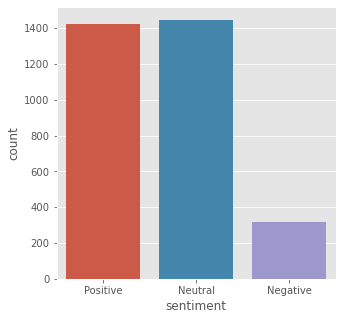

In [31]:
#visualizations

fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = dnc_tweet)

Text(0.5, 1.0, 'Distribution of sentiments')

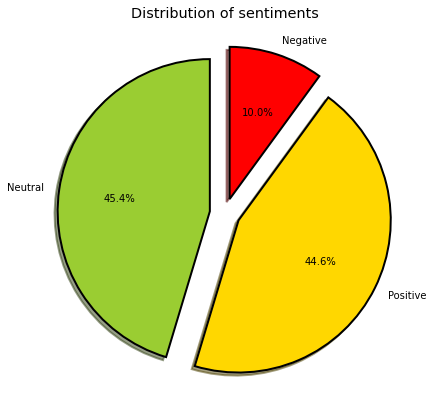

In [32]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = dnc_tweet['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [33]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [34]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Positive Tweets

In [35]:
# wordclouds
from wordcloud import WordCloud

pos_dnc = dnc_tweet[dnc_tweet.sentiment == 'Positive']
pos_dnc = pos_dnc.sort_values(['polarity'], ascending= False)
pos_dnc

,tweet,polarity,sentiment
2354,president said best olympians representing cou...,1.000000,Positive
392,greatest strength,1.000000,Positive
1539,2021 dnc raised 137mand already best grassroot...,1.000000,Positive
960,2021 greatest year job growth president history,1.000000,Positive
1163,vaccines best protection covid19 variants get ...,1.000000,Positive
...,...,...,...
101,millions americans paid social security medica...,0.016667,Positive
7,millions americans paid social security medica...,0.016667,Positive
3120,expanding analysis weve also added reddit tikt...,0.016667,Positive
294,republican leaders come podium complain arent ...,0.012500,Positive


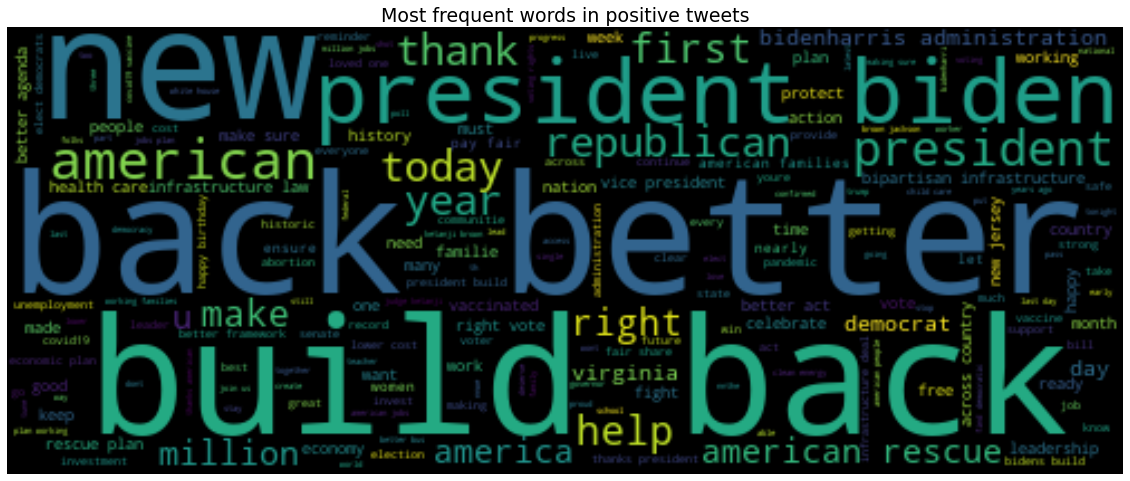

In [36]:
text_pos = ' '.join([word for word in pos_dnc['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=300, width=500, height=200).generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

## Neutral Tweets

In [37]:
neu_dnc = dnc_tweet[dnc_tweet.sentiment == 'Neutral']
neu_dnc = neu_dnc.sort_values(['polarity'], ascending= False)
neu_dnc

,tweet,polarity,sentiment
2,last night republicans nominated slew ultramag...,0.0,Neutral
2238,bidenharris administration working around cloc...,0.0,Neutral
2233,17 days nations troops executed largest airlif...,0.0,Neutral
2232,join conclude bus tour across country telling ...,0.0,Neutral
2231,president promised end war afghanistan nnhe ke...,0.0,Neutral
...,...,...,...
1058,big deal president biden knows consumers freed...,0.0,Neutral
1057,republican lawmakers based votesnnvoting right...,0.0,Neutral
1056,bipartisan infrastructure law replace 100 nati...,0.0,Neutral
1055,republicans voted lowering health care premium...,0.0,Neutral


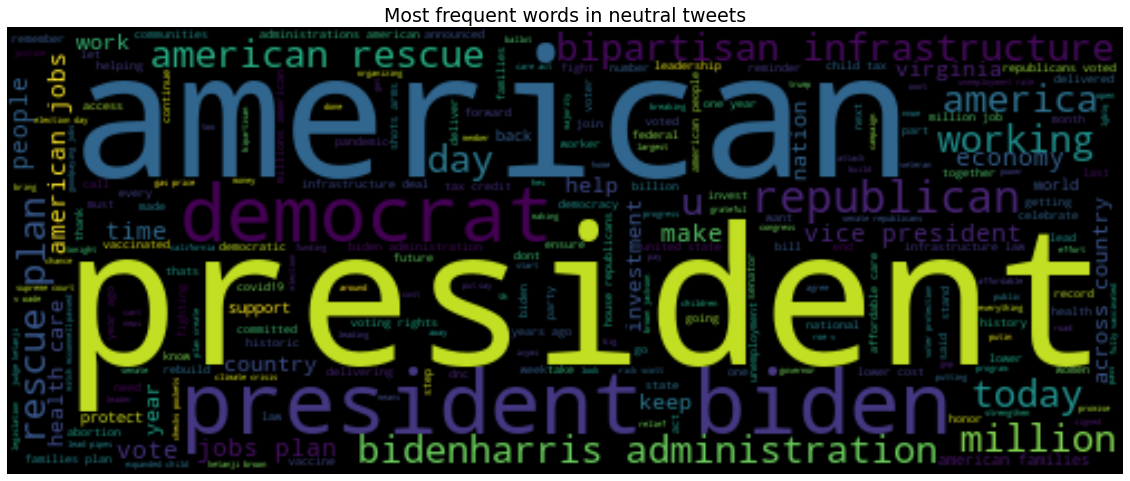

In [38]:
text_neu = ' '.join([word for word in neu_dnc['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=300, width=500, height=200).generate(text_neu)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

## Negative Tweets

In [39]:
neg_dnc = dnc_tweet[dnc_tweet.sentiment == 'Negative']
neg_dnc = neg_dnc.sort_values(['polarity'], ascending= False)
neg_dnc

,tweet,polarity,sentiment
1253,fourweek average new unemployment claims lowes...,-0.006818,Negative
526,new unemployment claims fell prepandemic avera...,-0.006818,Negative
803,full blocking sanctions two large russian fina...,-0.007143,Negative
1449,case supreme court heard today could undermine...,-0.007143,Negative
72,mitch mcconnell made clear federal ban abortio...,-0.008333,Negative
...,...,...,...
3162,mourn anniversary horrific tragedy virginia te...,-1.000000,Negative
2247,carried todays horrific attack president message,-1.000000,Negative
1977,republicans blocking democrats raising debt ce...,-1.000000,Negative
922,across country republican leaders moving forwa...,-1.000000,Negative


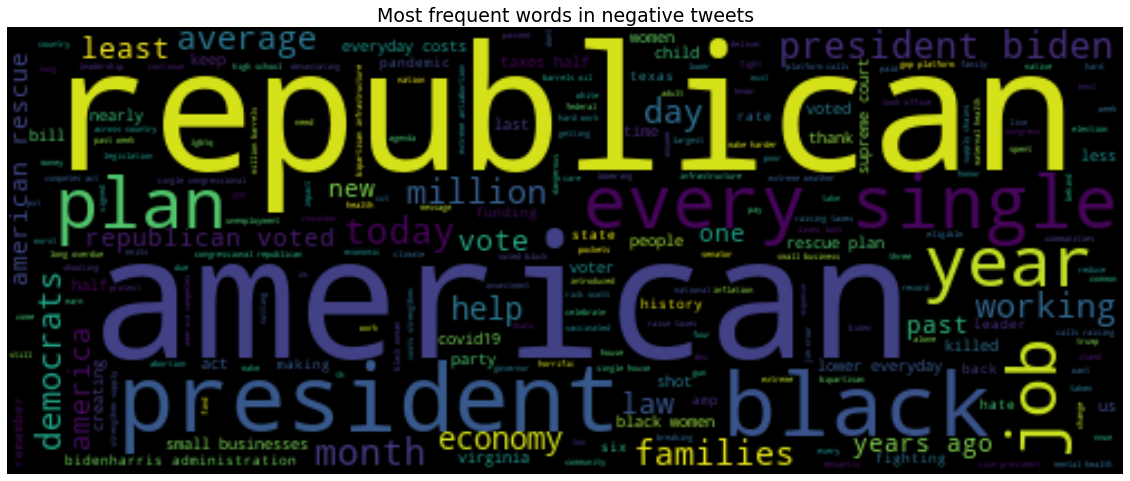

In [40]:
text_neg = ' '.join([word for word in neg_dnc['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=300, width=500, height=200).generate(text_neg)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

# Logistic Regression Model

In [41]:
#vectorize for a bigram model, using 2 words
vect = CountVectorizer(ngram_range=(1,2)).fit(dnc_tweet['tweet'])

In [42]:
#extract features
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 30 features:\n {}".format(feature_names[:30]))

Number of features: 25357

First 30 features:
 ['10', '10 511', '10 days', '10 ive', '10 last', '10 million', '10 people', '10 tennesseans', '10 utahns', '10 years', '100', '100 americans', '100 billion', '100 days', '100 daysjoin', '100 daysnnhe', '100 daysnnhed', '100 daysthats', '100 dayswith', '100 focused', '100 lead', '100 million', '100 nations', '100 republican', '100 union', '100 years', '1000', '1000 month', '1000 per', '100000']


In [43]:
#build model
X = dnc_tweet['tweet']
y = dnc_tweet['sentiment']
X = vect.transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [45]:
print("Size of x_train:", (X_train.shape))
print('Size of y_train:', (y_train.shape))
print('Size of x_test:', (X_test.shape))
print('Size of y_test:', (y_test.shape))

Size of x_train: (2550, 25357)
Size of y_train: (2550,)
Size of x_test: (638, 25357)
Size of y_test: (638,)


In [46]:
#Train model using Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print('Test accuracy: {:.2f}%'.format(logreg_acc*100))

Test accuracy: 82.76%


In [47]:
#print confusion matrix to predict sentiment classification
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 16  27  13]
 [  1 273  11]
 [  3  55 239]]


              precision    recall  f1-score   support

    Negative       0.80      0.29      0.42        56
     Neutral       0.77      0.96      0.85       285
    Positive       0.91      0.80      0.85       297

    accuracy                           0.83       638
   macro avg       0.83      0.68      0.71       638
weighted avg       0.84      0.83      0.82       638



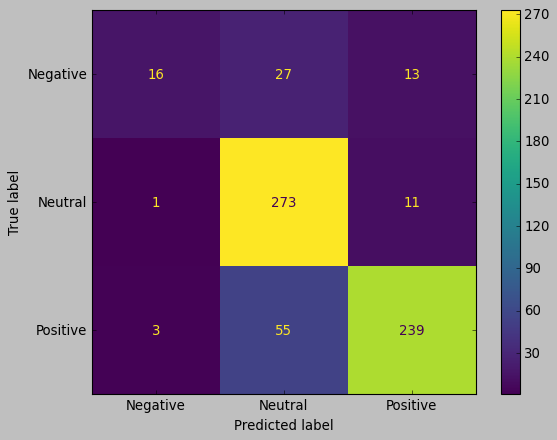

In [48]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [95]:
dnc_tweet.to_csv('dnc_sentiment_final.csv', index= False)

In [52]:
pos_dnc.to_csv('positive_dnc.csv', index= False)

In [53]:
neg_dnc.to_csv('negative_dnc.csv', index= False)
neu_dnc.to_csv('neutral_dnc.csv', index= False)